In [7]:
import os
import cv2
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm

# === Config ===
IMAGE_FOLDER = r"C:\Users\mcsmu\Desktop\Line Following SVM\processed_dataset"
OUTPUT_CSV = r"C:\Users\mcsmu\Desktop\Line Following SVM\labels.csv"

# === HSV Range for Green Line ===
LOWER_HSV = np.array([70, 50, 50])
UPPER_HSV = np.array([90, 255, 255])

# === Improved Feature Extraction (Same as Training) ===
def extract_features(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, LOWER_HSV, UPPER_HSV)
    height, width = mask.shape

    bands = [mask[int(height * 0.6):int(height * 0.7), :],
             mask[int(height * 0.7):int(height * 0.8), :],
             mask[int(height * 0.8):, :]]

    features = []
    for band in bands:
        indices = np.column_stack(np.where(band > 0))
        if indices.size > 0:
            avg_x = np.mean(indices[:, 1]) / width * 2 - 1  # normalize to [-1.0, 1.0]
        else:
            avg_x = 0.0
        features.append(avg_x)

    return features

# === Labeling: Use average of 3-band feature as 1 steering label ===
image_paths = sorted(glob(os.path.join(IMAGE_FOLDER, "*.png")))
labels = []

for path in tqdm(image_paths, desc="Labeling images with improved logic"):
    image = cv2.imread(path)
    if image is None:
        continue

    try:
        features = extract_features(image)
        label = round(float(np.mean(features)), 4)  # Final steering label
        filename = os.path.basename(path)
        labels.append([filename, label])
    except Exception as e:
        print(f"Error with {path}: {e}")

# === Save to CSV ===
df = pd.DataFrame(labels, columns=["filename", "Maneuvering"])
df.to_csv(OUTPUT_CSV, index=False)

print(f"\n✅ Labeling complete. Total labeled images: {len(df)}")
print(f"📄 Saved to: {OUTPUT_CSV}")


Labeling images with improved logic: 100%|███████████████████████████████████████████| 977/977 [01:51<00:00,  8.74it/s]



✅ Labeling complete. Total labeled images: 977
📄 Saved to: C:\Users\mcsmu\Desktop\Line Following SVM\labels.csv


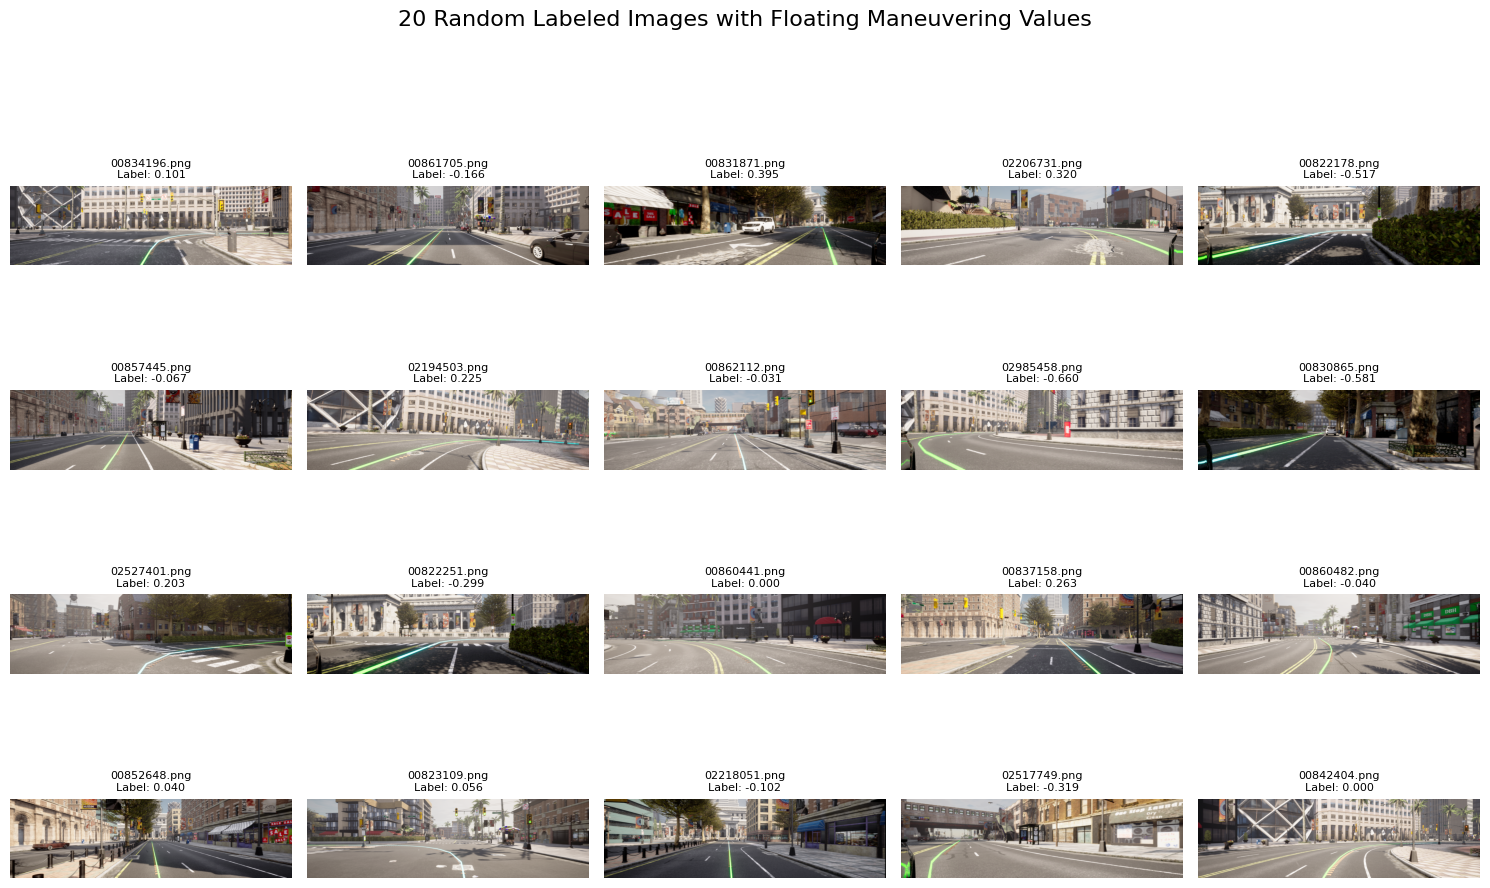

In [9]:
import os
import cv2
import random
import pandas as pd
import matplotlib.pyplot as plt

# === Paths ===
IMAGE_FOLDER = r"C:\Users\mcsmu\Desktop\Line Following SVM\processed_dataset"
LABEL_CSV = r"C:\Users\mcsmu\Desktop\Line Following SVM\labels.csv"

# === Load labeled CSV ===
df = pd.read_csv(LABEL_CSV)
df['filename'] = df['filename'].str.lower()

# === Pick 20 random samples ===
sampled_df = df.sample(n=20, random_state=42).reset_index(drop=True)

# === Plotting ===
fig, axes = plt.subplots(4, 5, figsize=(15, 10))
fig.suptitle("20 Random Labeled Images with Floating Maneuvering Values", fontsize=16)

for idx, ax in enumerate(axes.flat):
    if idx >= len(sampled_df):
        ax.axis('off')
        continue

    row = sampled_df.iloc[idx]
    image_path = os.path.join(IMAGE_FOLDER, row['filename'])
    image = cv2.imread(image_path)

    if image is None:
        ax.axis('off')
        continue

    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax.imshow(img_rgb)
    ax.axis('off')
    ax.set_title(f"{row['filename']}\nLabel: {row['Maneuvering']:.3f}", fontsize=8)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
